In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from specutils.spectra import SpectralRegion

import astropaul.lbt as lbt

%load_ext autoreload
%autoreload 2


In [50]:
base_dir = "../../Files/PEPSI Spectra/"

blue_spectra = [
    # (lbt.PepsiSpectrum.read(base_dir + "202310/pepsib.20231102.043.dxt.bwl"), (.33, .75, .25)),
    (lbt.PepsiSpectrum.read(base_dir + "202409/pepsib.20240920.072.dxt.bwl"), (.31, .83, .32)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241222.004.dxt.bwl"), (.83, .71, .21)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241223.027.dxt.bwl"), (.93, .18, .68)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241224.025.dxt.bwl"), (.12, .68, .17)),
]

red_spectra = [
    (lbt.PepsiSpectrum.read(base_dir + "202310/pepsir.20231102.045.dxt.bwl"), (.33, .75, .25)),
    (lbt.PepsiSpectrum.read(base_dir + "202409/pepsir.20240920.015.dxt.bwl"), (.31, .83, .32)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241222.000.dxt.bwl"), (.83, .71, .21)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241223.023.dxt.bwl"), (.93, .18, .68)),
    (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241224.021.dxt.bwl"), (.12, .68, .17)),
]

hd38979b = lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241222.006.dxt.bwl", radial_velocity=11.66 * u.km / u.s)
hd38979r = lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241222.002.dxt.bwl", radial_velocity=11.66 * u.km / u.s)
hip104548b = lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241223.011.dxt.bwl", radial_velocity=-9 * u.km / u.s)
hip104548r = lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241223.007.dxt.bwl", radial_velocity=-9 * u.km / u.s)
hip112051b = lbt.PepsiSpectrum.read(base_dir + "202510/pepsib.20251018.030.dxt.bwl", radial_velocity=9.09 * u.km / u.s)
hip112051r = lbt.PepsiSpectrum.read(base_dir + "202510/pepsir.20251018.020.dxt.bwl", radial_velocity=9.09 * u.km / u.s)

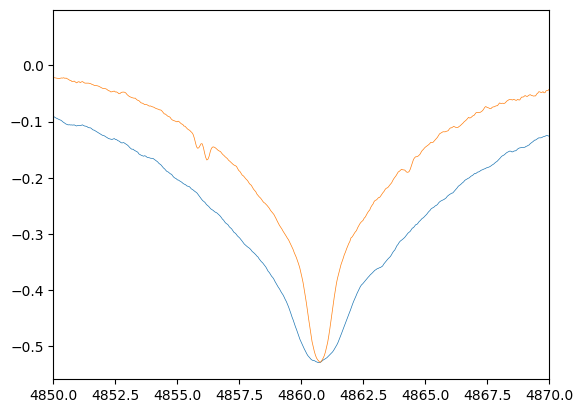

<Quantity 21.86583719 km / s>

In [62]:
from specutils.manipulation import box_smooth

foo = box_smooth(lbt.read_pepsi_file("../../Files/PEPSI Spectra/202412/pepsib.20241222.006.dxt.bwl", radial_velocity=11.66 * u.km / u.s), width=5)
bar = box_smooth(
    lbt.read_pepsi_file("../../Files/PEPSI Spectra/202412/pepsib.20241223.011.dxt.bwl", radial_velocity=-9 * u.km / u.s),
    width=5,
)

_, ax = plt.subplots()
ax.plot(foo.spectral_axis, foo.flux - .03, linewidth=0.5)
ax.plot(bar.spectral_axis, bar.flux, linewidth=0.5)
# ax.plot(hip112051b.spectral_axis, hip112051b.flux, linewidth=0.5)
# ax.set_xlim(4859, 4862)
ax.set_xlim(4850, 4870)
# ax.set_xlim(4800, 4900)
# ax.set_ylim(-.55, -.2)
plt.show()
# foo.shift_spectrum_to(radial_velocity=foo.radial_velocity + 10 * u.km / u.s)
foo.radial_velocity

In [132]:
[(spec.obs_time.iso, spec.spectrum.radial_velocity) for spec in blue_spectra + [hd38979b]]

[('2024-09-20 08:35:06.618', <Quantity 28428.09287923 m / s>),
 ('2024-12-22 10:14:18.653', <Quantity -5520.84377291 m / s>),
 ('2024-12-23 07:15:11.571', <Quantity -6139.65320661 m / s>),
 ('2024-12-24 05:15:03.994', <Quantity -6633.2506196 m / s>),
 ('2024-12-22 10:30:25.632', <Quantity 21865.8371882 m / s>)]

In [71]:
jd_offset = 2460000
linewidth = 0.5


def do_plot(name, boxcar, region_name, offset, major, minor, spectra, templates, find_lines, line_boxcar, line_thresh):
    fig, (ax1, ax2, *axts) = plt.subplots(1, 2 + len(templates), figsize=(25, 8))
    y_offset = 0
    region = regions[region_name]
    tss = []
    for template in templates:
        ts = template.copy()
        ts.extract_region(region)
        tss.append(ts)
    for ps, (aa, ba, bb) in spectra:
        ps = ps.copy()
        ps.extract_region(region)
        if boxcar > 1:
            ps.smooth(boxcar=boxcar)
            if template:
                ts.smooth(boxcar)
        # (line,) = ax1.plot(
        ax1.plot(
            ps.spectrum.spectral_axis,
            ps.spectrum.flux + y_offset,
            label=f"{ps.obs_time.jd - jd_offset:.5f} Aa {aa:.2f} Ba {ba:.2f} Bb {bb:.2f}",
            linewidth=linewidth,
        )
        # ax1.text(
        #     region.bounds[0].value,
        #     ps.spectrum.flux[0] + y_offset + offset / 10,
        #     f"Aa {aa:.2f} Ba {ba:.2f} Bb {bb:.2f}",
        #     color=line.get_color(),
        # )
        y_offset -= offset
        auto_corr, auto_lag = ps.correlate(ps)
        ax2.plot(auto_lag, auto_corr)
        for ts, axt in zip(tss, axts):
            corr, lag = ps.correlate(ts)
            axt.plot(lag, corr)
    for ts, axt in zip(tss, axts):
        # (line,) = ax1.plot(
        ax1.plot(ts.spectrum.spectral_axis, ts.spectrum.flux + y_offset, label=template.target_name, linewidth=linewidth)
        y_offset -= offset
    ax1.set_title(f"{name} - {region_name}")
    ax1.set_xlabel(r"Wavelength, ($\AA$)")
    ax1.xaxis.set_major_locator(MultipleLocator(major))
    ax1.xaxis.set_minor_locator(MultipleLocator(minor))
    ax1.set_ylabel("Flux (au)")
    ax1.legend(title=f"JD - {jd_offset}", loc="lower right")
    if offset != 0:
        ax1.text(0.05, 0.06, f"Vertical offset {offset}", ha="left", va="bottom", transform=ax1.transAxes)
    if boxcar > 1:
        ax1.text(0.05, 0.035, f"Boxcar Smoothing {boxcar} pixels", ha="left", va="bottom", transform=ax1.transAxes)
    else:
        ax1.text(0.05, 0.035, "No Smoothing", ha="left", va="bottom", transform=ax1.transAxes)
    scale = 2 / (region.bounds[1] + region.bounds[0]) * 299792.458
    ax1.text(0.05, 0.005, f"1 $\\AA$ = {scale.value:.0f} km/s at plot center", ha="left", va="bottom", transform=ax1.transAxes)
    ax1.grid(axis="x", color="0.70", which="major")
    ax1.grid(axis="x", color="0.95", which="minor")
    ax2.set_title("Auto Correlation")
    ax2.set_xlim(0, 1750)
    ax2.xaxis.set_major_locator(MultipleLocator(250))
    ax2.xaxis.set_minor_locator(MultipleLocator(50))
    ax2.set_xlabel("Velocity (km/s)")
    ax2.grid(axis="x", color="0.70", which="major")
    ax2.grid(axis="x", color="0.95", which="minor")
    for axt in axts:
        axt.set_title(f"Correlation to {template.target_name}")
        axt.set_xlim(-1000, 1000)
        axt.xaxis.set_major_locator(MultipleLocator(250))
        axt.xaxis.set_minor_locator(MultipleLocator(50))
        axt.set_xlabel("Velocity (km/s)")
        axt.grid(axis="x", color="0.70", which="major")
        axt.grid(axis="x", color="0.95", which="minor")
    fig.tight_layout()
    plt.savefig(f"{name} - {region_name}.png")
    plt.show()
    plt.close()

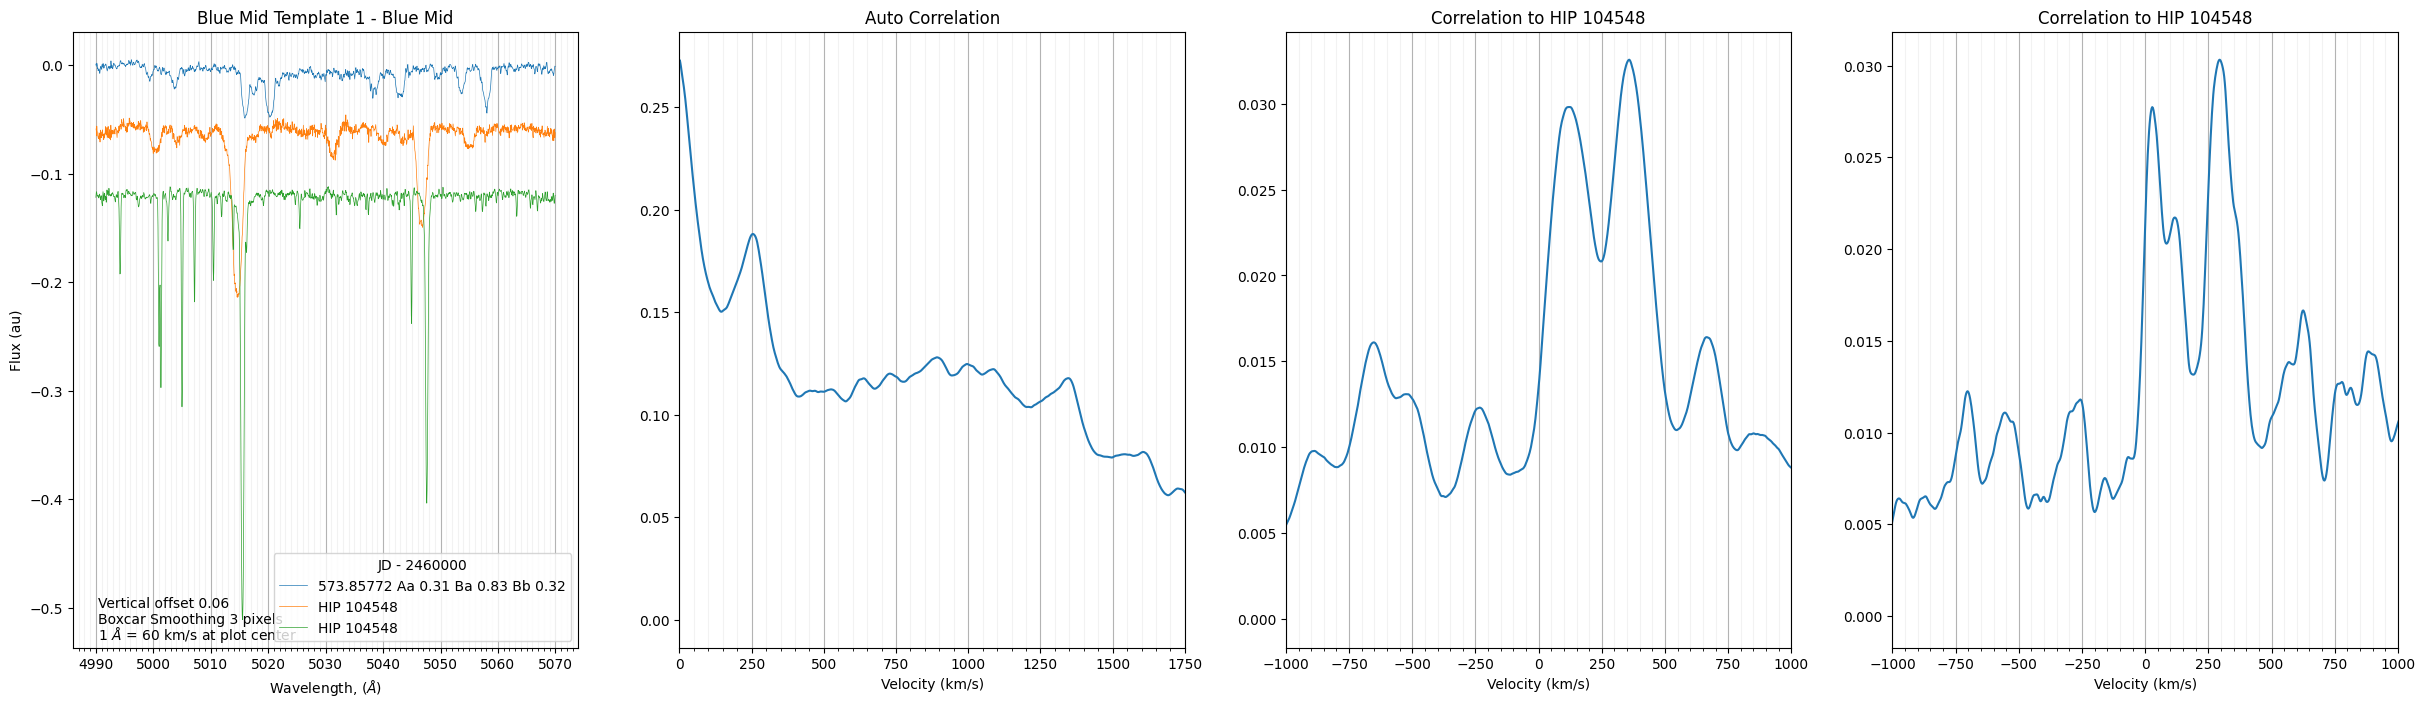

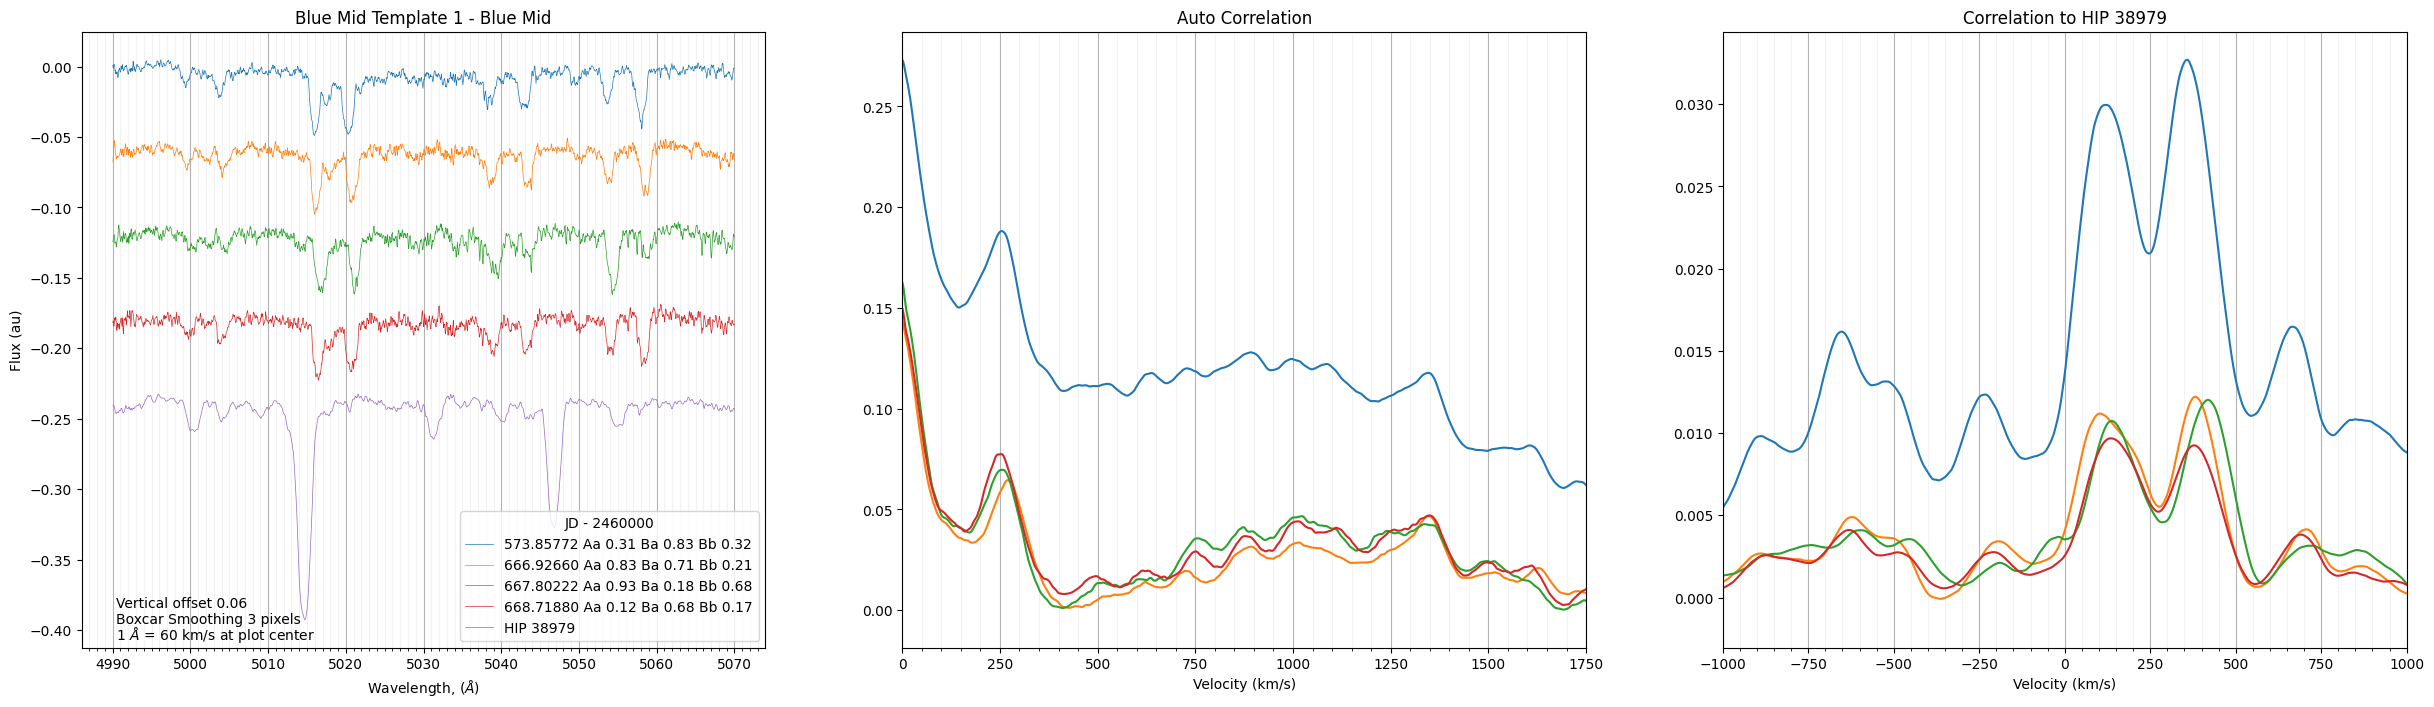

In [31]:
regions = {
    "Blue": SpectralRegion(4930 * u.AA, 5441 * u.AA),
    "Blue Mid": SpectralRegion(4990 * u.AA, 5070 * u.AA),
    "Blue Mid Tight": SpectralRegion(5025 * u.AA, 5065 * u.AA),
    "Blue Zoom": SpectralRegion(5010 * u.AA, 5025 * u.AA),
    "Hbeta Wide": SpectralRegion(4840 * u.AA, 4885 * u.AA),
    "Hbeta Narrow": SpectralRegion(4858 * u.AA, 4865 * u.AA),
    "Red": SpectralRegion(7419 * u.AA, 9067 * u.AA),
    "Red Mid": SpectralRegion(7590 * u.AA, 7690 * u.AA),
    "Oxygen 777": SpectralRegion(7750 * u.AA, 7797 * u.AA),
    "Paschen": SpectralRegion(8500 * u.AA, 8900 * u.AA),
    "Paschen Narrow": SpectralRegion(8520 * u.AA, 8570 * u.AA),
}

tasks = [
    # ("Templates", 9, "Blue", 0.25, 50, 10, [(hip104548b, (0, 0, 0))], hd38979b, False, 50, 0.007),
    # ("Templates", 9, "Blue", 0.07, 50, 10, [hip104548b, hip112051b], hd38979b, False, 50, 0.007),
    # ("All Blue", 9, "Blue", 0.07, 50, 10, blue_spectra, hd38979b, False, 50, 0.007),
    # ("All Blue", 9, "Blue", 0.07, 50, 10, blue_spectra, hip104548b, False, 50, 0.007),
    ("Blue Mid Template 1", 3, "Blue Mid", 0.06, 10, 1, [blue_spectra[0]], [hd38979b, hip104548b], False, 50, 0.005),
    ("Blue Mid Template 1", 3, "Blue Mid", 0.06, 10, 1, blue_spectra, [hd38979b], False, 50, 0.005),
    # ("Blue Mid Template 2", 3, "Blue Mid", 0.06, 10, 1, blue_spectra, [hip104548b], False, 50, 0.005),
    # ("Blue Mid Auto", 3, "Blue Mid", 0.06, 10, 1, blue_spectra, None, False, 50, 0.007),
    # ("H beta", 1, "Hbeta Wide", 0.2, 5, 1, blue_spectra, hd38979b, False, 50, 0.01),
    # ("H beta Narrow", 3, "Hbeta Narrow", 0.07, 5, 1, blue_spectra, None, False, 50, 0.01),
    # ("Red", 5, "Red", 0.075, 250, 25, red_spectra, hd38979r, False, 50, 0.01),
    # # ("Red Mid", 5, "Red Mid", 1, 10, 1, red_spectra, hd38979r, False, 50, 0.01),
    # ("Oxygen 777", 1, "Oxygen 777", 0.075, 5, 1, red_spectra, hd38979r, False, 50, 0.01),
    # ("Paschen", 9, "Paschen", 0.12, 50, 10, red_spectra, hd38979r, False, 50, .01),
    # ("Paschen Narrow", 1, "Paschen Narrow", 0.12, 5, 1, red_spectra, hd38979r, False, 50, .01),
]

for task in tasks:
    do_plot(*task)

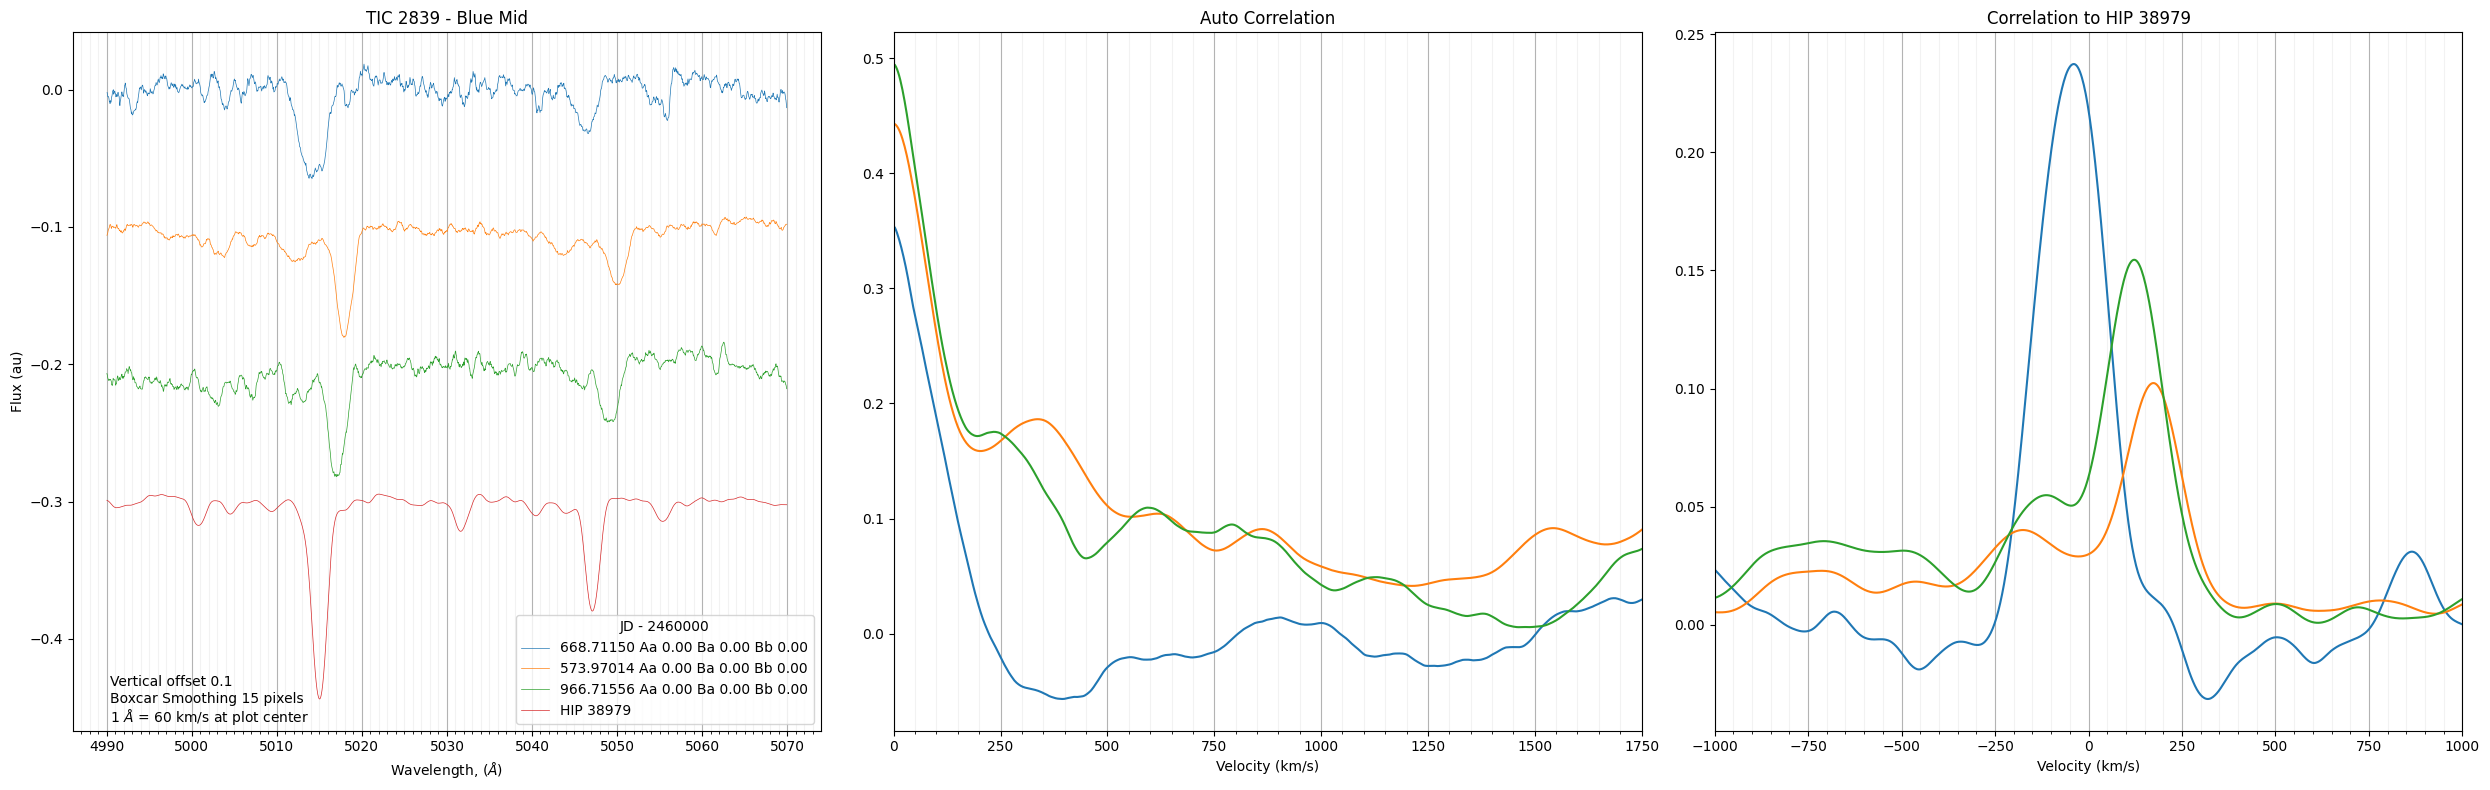

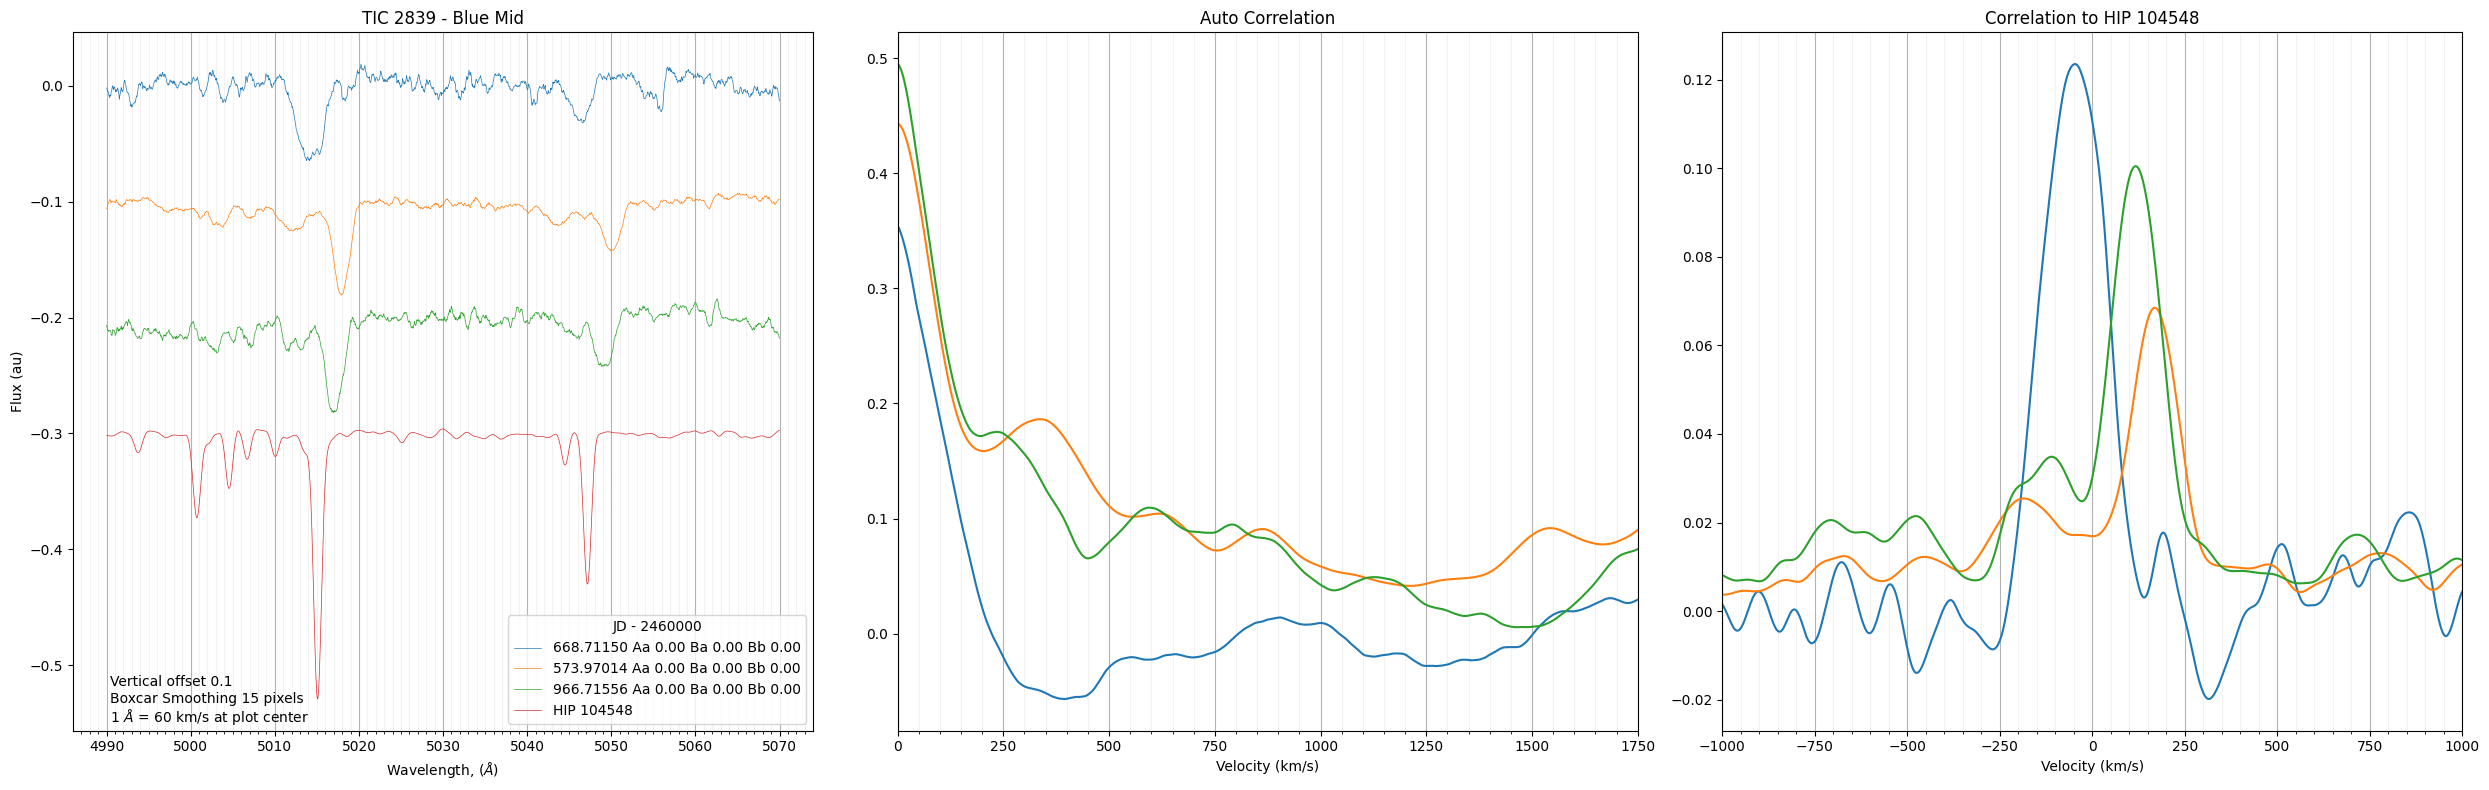

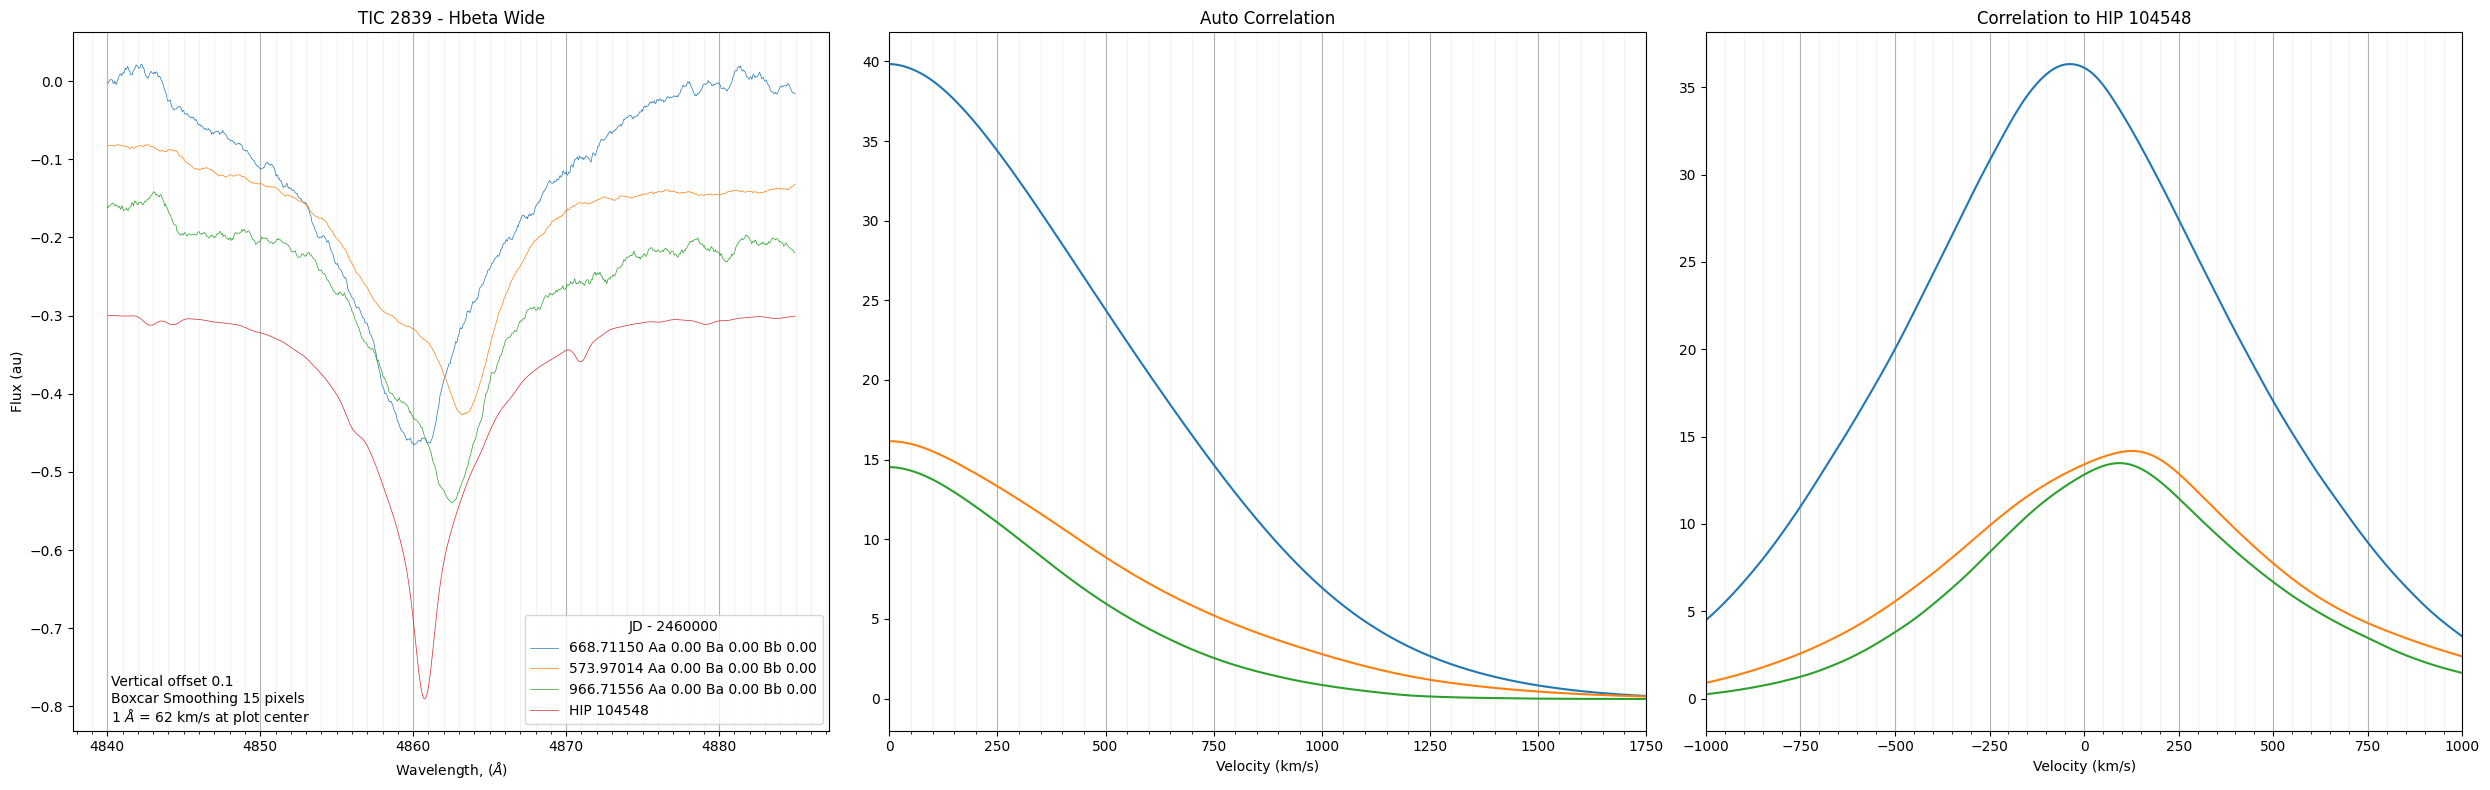

In [72]:
tic5285 = lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241225.043.dxt.bwl")
tic2600 = lbt.PepsiSpectrum.read(base_dir + "202409/pepsib.20240920.077.dxt.bwl")
tic2839 = [
     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241224.024.dxt.bwl"), (0,0,0)),
     (lbt.PepsiSpectrum.read(base_dir + "202409/pepsib.20240920.079.dxt.bwl"), (0,0,0)),
     (lbt.PepsiSpectrum.read(base_dir + "202510/pepsib.20251018.028.dxt.bwl"), (0,0,0)),
]

tasks = [
    # ("TIC 5285", 9, "Blue", 0.1, 50, 10, [(tic5285, (0, 0, 0))], hd38979b, False, 50, 0.007),
    # ("TIC 5285", 9, "Blue", 0.1, 50, 10, [(tic5285, (0, 0, 0))], hip104548b, False, 50, 0.007),
    # ("TIC 5285", 9, "Hbeta Wide", 0.1, 50, 10, [(tic5285, (0, 0, 0))], hd38979b, False, 50, 0.007),
    # ("TIC 5285", 9, "Hbeta Wide", 0.1, 50, 10, [(tic5285, (0, 0, 0))], hip104548b, False, 50, 0.007),
    # ("TIC 2600", 9, "Blue", 0.1, 50, 10, [(tic2600, (0, 0, 0))], hd38979b, False, 50, 0.007),
    # ("TIC 2600", 9, "Hbeta Wide", 0.1, 50, 10, [(tic2600, (0, 0, 0))], hd38979b, False, 50, 0.007),
    # ("TIC 2839", 15, "Blue", 0.1, 50, 10, tic2839, [hd38979b, hip104548b], False, 50, 0.007),
    # ("TIC 2839", 15, "Blue", 0.1, 50, 10, tic2839, [hip104548b], False, 50, 0.007),
    ("TIC 2839", 15, "Blue Mid", 0.1, 10, 1, tic2839, [hd38979b], False, 50, 0.007),
    ("TIC 2839", 15, "Blue Mid", 0.1, 10, 1, tic2839, [hip104548b], False, 50, 0.007),
    ("TIC 2839", 15, "Hbeta Wide", 0.1, 10, 1, tic2839, [hip104548b], False, 50, 0.007),
    # ("TIC 2839", 9, "Blue Mid", 0.1, 10, 1, tic2839, hip104548b, False, 50, 0.007),
    # ("TIC 2839", 15, "Blue Mid", 0.1, 10, 1, tic2839, None, False, 50, 0.007),
    # ("TIC 2839", 9, "Hbeta Wide", 0.1, 10, 1, tic2839, hd38979b, False, 50, 0.007),
]

for task in tasks:
    do_plot(*task)

In [36]:
from functools import partial
from pathlib import Path

from astropaul.database import database_connection
import astropaul.html as html
import astropaul.lbt as lbt
import astropaul.phase as ph
import astropaul.targetlistcreator as tlc
from specutils import SpectralRegion

%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter('always')  # Show all warnings
warnings.showwarning = warnings._showwarnmsg_impl  # Use default formatting with stack trace


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
html_dir = "../../Observing Files/RV Study"
phase_event_defs = [
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.05)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.18)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.32)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.45)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.55)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.68)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.82)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.95)),
]

with database_connection() as conn:
    name = "RV Study"
    creator = tlc.TargetListCreator(name=name, connection=conn, phase_event_defs=phase_event_defs)
    creator.steps = [
        tlc.add_targets,
        # partial(tlc.filter_targets, criteria=lambda df: df["Target Name"] == "TIC 283940788"),
        # partial(tlc.filter_targets, criteria=lambda df: df["Target Type"] == "RV Standard"),
        partial(tlc.add_database_table, table_name="ephemerides"),
        partial(tlc.add_database_table, table_name="pepsi_observations"),
        partial(tlc.filter_targets, criteria=lambda df: df["Num PEPSI Observations"] > 0),
        tlc.ancillary_data_from_tess,
        partial(tlc.add_columns_from_sql, table_name="rv_calibration_targets", primary_cols=["RV"]),
        tlc.add_tess_catalog_associations,
        tlc.add_lists,
        partial(tlc.add_database_table, table_name="dssi_observations"),
        partial(tlc.add_database_table, table_name="speckle_detections"),
        tlc.add_pepsi_evaluations,
        tlc.add_rv_status,
        partial(tlc.add_member_phases, table_name="DSSI Observations", time_column="Mid JD"),
        partial(tlc.add_member_phases, table_name="PEPSI Observations", time_column="Mid JD"),
    ]
    tl = creator.calculate(verbose=False)
    html.render_observing_pages(tl, None, {}, html_dir)


In [ ]:
spectra_by_file = {
    path.name: lbt.read_pepsi_file(path)
    for path in list(Path("../../Files/PEPSI Spectra/").glob("20*/*.bwl"))
    + list(Path("../../Files/PEPSI Spectra/").glob("20*/*.nor"))
}

# do additional spectrum shift for targets with known radial velocity
rv_standards = {
    target_name: rv
    for target_name, rv in tl.target_list[tl.target_list["RV"] == tl.target_list["RV"]][["Target Name", "RV"]].to_numpy()
}
observations = tl.other_lists["PEPSI Observations"]
for target_name, rv in rv_standards.items():
    for spectrum_file in observations[observations["Target Name"] == target_name]["Spectrum File"]:
        rv_spectrum = spectra_by_file[spectrum_file]
        print(f"shifting {spectrum_file} by {rv} on top of {rv_spectrum.radial_velocity}") 
        rv_spectrum.shift_spectrum_to(radial_velocity=rv_spectrum.radial_velocity + rv * u.km / u.s)

regions = {
    "Blue": {
        "Blue Big": SpectralRegion(4930 * u.AA, 5441 * u.AA),
        "Blue Mid": SpectralRegion(4990 * u.AA, 5070 * u.AA),
        "Blue Mid Tight": SpectralRegion(5025 * u.AA, 5065 * u.AA),
        "Blue Zoom": SpectralRegion(5010 * u.AA, 5025 * u.AA),
        "Hbeta Wide": SpectralRegion(4840 * u.AA, 4885 * u.AA),
        "Hbeta Narrow": SpectralRegion(4858 * u.AA, 4865 * u.AA),
    },
    "Red": {
        "Red Big": SpectralRegion(7419 * u.AA, 9067 * u.AA),
        "Oxygen 777": SpectralRegion(7750 * u.AA, 7797 * u.AA),
        "Paschen": SpectralRegion(8500 * u.AA, 8900 * u.AA),
        "Paschen Narrow": SpectralRegion(8520 * u.AA, 8570 * u.AA),
    },
}

shifting pepsib.20251018.030.dxt.bwl by 9.09 on top of -12.889327002408754 km / s
shifting pepsir.20251018.020.dxt.bwl by 9.09 on top of -12.889326985833497 km / s
shifting pepsib.20241222.007.dxt.bwl by 14.864 on top of 12.542952267266527 km / s
shifting pepsir.20241222.003.dxt.bwl by 14.864 on top of 12.542952259411587 km / s
shifting pepsib.20250408.068.dxt.bwl by 4.455 on top of -10.63526543975757 km / s
shifting pepsir.20250408.056.dxt.bwl by 4.455 on top of -10.635265406074517 km / s
shifting pepsib.20241223.011.dxt.bwl by -9.0 on top of -17.35060590563089 km / s
shifting pepsir.20241223.007.dxt.bwl by -9.0 on top of -17.350607159359377 km / s
shifting pepsib.20241222.006.dxt.bwl by 11.66 on top of 10.205837188196728 km / s
shifting pepsir.20241222.002.dxt.bwl by 11.66 on top of 10.20583721082961 km / s
shifting pepsib.20250408.067.dxt.bwl by 11.66 on top of -27.575668361283523 km / s
shifting pepsir.20250408.055.dxt.bwl by 11.66 on top of -27.575668290056512 km / s


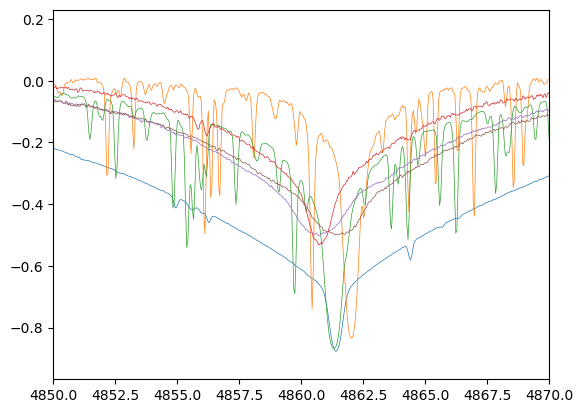

In [103]:
_, ax = plt.subplots()
for target_name, rv in rv_standards.items():
    for spectrum_file in observations[observations["Target Name"] == target_name]["Spectrum File"]:
        if "pepsir" in spectrum_file:
            continue
        rv_spectrum = spectra_by_file[spectrum_file]
        ax.plot(rv_spectrum.spectral_axis, rv_spectrum.flux, linewidth=0.5)
# ax.set_xlim(4900, 5000)
ax.set_xlim(4850, 4870)
# ax.set_xlim(4800, 4900)
# ax.set_ylim(-.1, 0)
plt.show()



In [121]:
regions

{'Blue': {'Blue Big': Spectral Region, 1 sub-regions:
    (4930.0 Angstrom, 5441.0 Angstrom) ,
  'Blue Mid': Spectral Region, 1 sub-regions:
    (4990.0 Angstrom, 5070.0 Angstrom) ,
  'Blue Mid Tight': Spectral Region, 1 sub-regions:
    (5025.0 Angstrom, 5065.0 Angstrom) ,
  'Blue Zoom': Spectral Region, 1 sub-regions:
    (5010.0 Angstrom, 5025.0 Angstrom) ,
  'Hbeta Wide': Spectral Region, 1 sub-regions:
    (4840.0 Angstrom, 4885.0 Angstrom) ,
  'Hbeta Narrow': Spectral Region, 1 sub-regions:
    (4858.0 Angstrom, 4865.0 Angstrom) },
 'Red': {'Red Big': Spectral Region, 1 sub-regions:
    (7419.0 Angstrom, 9067.0 Angstrom) ,
  'Oxygen 777': Spectral Region, 1 sub-regions:
    (7750.0 Angstrom, 7797.0 Angstrom) ,
  'Paschen': Spectral Region, 1 sub-regions:
    (8500.0 Angstrom, 8900.0 Angstrom) ,
  'Paschen Narrow': Spectral Region, 1 sub-regions:
    (8520.0 Angstrom, 8570.0 Angstrom) }}

In [ ]:
templates = {
    "Blue": spectra_by_file["pepsib.20241222.006.dxt.bwl"],
    "Red": spectra_by_file["pepsir.20241222.002.dxt.bwl"],
    # "Blue": spectra_by_file["pepsib.20241223.011.dxt.bwl"]
    # "Red": spectra_by_file["pepsir.20241223.007.dxt.bwl"]
}

observations = observations[observations["Evaluation"] > 2]
for (target_name, arm), observation_rows in observations.groupby(["Target Name", "Arm"]):
    spectra = observation_rows["Spectrum File"]
    observation_data = [
        (spectra_by_file[file], jd.jd, phases)
        for file, jd, phases in observation_rows[["Spectrum File", "Mid JD", "Member Phases"]].to_numpy()
    ]
    for region_name, region in regions[arm].items():
        print(target_name, arm, region_name)
        # do_plot(name, region, spectra, template)

HD 102870 Blue Blue Big
HD 102870 Blue Blue Mid
HD 102870 Blue Blue Mid Tight
HD 102870 Blue Blue Zoom
HD 102870 Blue Hbeta Wide
HD 102870 Blue Hbeta Narrow
HD 102870 Red Red Big
HD 102870 Red Oxygen 777
HD 102870 Red Paschen
HD 102870 Red Paschen Narrow
HD 65583 Blue Blue Big
HD 65583 Blue Blue Mid
HD 65583 Blue Blue Mid Tight
HD 65583 Blue Blue Zoom
HD 65583 Blue Hbeta Wide
HD 65583 Blue Hbeta Narrow
HD 65583 Red Red Big
HD 65583 Red Oxygen 777
HD 65583 Red Paschen
HD 65583 Red Paschen Narrow
HIP 104548 Blue Blue Big
HIP 104548 Blue Blue Mid
HIP 104548 Blue Blue Mid Tight
HIP 104548 Blue Blue Zoom
HIP 104548 Blue Hbeta Wide
HIP 104548 Blue Hbeta Narrow
HIP 104548 Red Red Big
HIP 104548 Red Oxygen 777
HIP 104548 Red Paschen
HIP 104548 Red Paschen Narrow
HIP 112051 Blue Blue Big
HIP 112051 Blue Blue Mid
HIP 112051 Blue Blue Mid Tight
HIP 112051 Blue Blue Zoom
HIP 112051 Blue Hbeta Wide
HIP 112051 Blue Hbeta Narrow
HIP 112051 Red Red Big
HIP 112051 Red Oxygen 777
HIP 112051 Red Paschen


In [9]:
base_dir = "../../Files/PEPSI Spectra/"  
# hd38979b.spectrum.flux + hd38979r.spectrum.flux
# Spectrum(hd38979b.spectrum.spectral_axis + hd38979r.spectrum.spectral_axis, hd38979b.spectrum.flux + hd38979r.spectrum.flux)
foo = lbt.read_pepsi_file(base_dir + "202409/pepsib.20240920.077.dxt.bwl")
foo.meta["Filename"]

'../../Files/PEPSI Spectra/202409/pepsib.20240920.077.dxt.bwl'